### Data Analysis in StackExchange Topic 'data science'

#### We are interested to know
(1). What is the trending in DS keywords
(2). Which keywords will attract most attention? Classfy posts

In [1]:
import xml.etree.ElementTree
import matplotlib.pyplot as plt
import re
e = xml.etree.ElementTree.parse('datascience.stackexchange.com/Posts.xml').getroot()

#### Obtain post's title, viewcount

In [2]:
import pandas as pd
post_list = []
score_list = []
vcount_list = []
id_list = []
with open('posts.txt', 'w') as f:
    count = 0
    for atype in e.findall('row'):
        posttype = atype.get('PostTypeId')
        if posttype == "1":
            str_id = atype.get('Id')
            id_list.append(int(str_id))
            
            str1 = atype.get('Body')
            str1 = (re.sub('\<.*?\>', '', str1))
            str1= str1.replace("\n", "")
            #str1 = str1.replace("--"," ")
            str1 = str1.replace("/"," ")
            str1 = str1.encode("utf-8")
            post_list.append(str1)
            
            str_score = atype.get('Score')
            score_list.append(int(str_score))
            
            str_view = atype.get('ViewCount')
            vcount_list.append(int(str_view))
            
            count += 1
            with open('posts.txt', 'a') as f:
                f.write(str1+'\n')
                
df = pd.DataFrame({'Id': id_list, 'Body':post_list, 'Score':score_list, 'ViewCount':vcount_list})
df = df[['Id','Body','Score']]

#### Shuffle the DataFrame

In [3]:
import numpy as np
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
print df.head()
print df.shape

         Id                                               Body  Score
1014   6217  I am new to the field of machine learning, but...      7
3119  13445  I am interested in clustering multivariate N t...      3
3150  13567  I am working on a fictional dataset with 25 fe...      3
144     595  I'm new to machine learning, but I have an int...      2
1722   9527  The code below doesn't give any errors but it ...      1
(6254, 3)


#### Process Documents into tokens

In [4]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    #return[try:porter.stem(word) except UnicodeDecodeError:print w  for word in text.split()]
    res = []
    for w in text.split():
        try:
            res+=[porter.stem(w)]
        except UnicodeDecodeError:
            res = res
    return res

#### Visualize the wordCloud in post bodies

In [5]:
from wordcloud import WordCloud
def visualCloud(string):
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

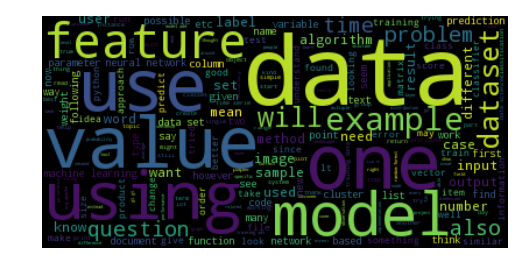

In [6]:
text = "".join(post_list)
text = text.lower()
visualCloud(text)

In [7]:
print df.iloc[[13]]['Body']

3921    I am using word2vec to train a big corpus of t...
Name: Body, dtype: object


In [8]:
#print text.split()
print df.shape

(6254, 3)


#### Select the title with top30 views, visualize the wordCloud

### Use NLP to extract key text from sentence

#### Separate the dataset into training and test sets

In [9]:
cut = int(df.shape[0]*0.7)
X_train = df.loc[:cut, 'Body'].values
y_train = df.loc[:cut, 'Score'].values
X_test = df.loc[cut:, 'Body'].values
y_test = df.loc[cut:, 'Score'].values
print X_train.shape, X_test.shape

(3693,) (2562,)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#### Process Documents into tokens

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LZ_Wang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [13]:
#gs_lr_tfidf.fit(X_train, y_train)